# California Maternity Hospital Random Forest Model
## Karla Knudson
### Insight Data Science - Health Data 2018

### Background and Goals of this Project: 
Here, I conduct Random Forest analysis to determine whether there are consistent hospital features or demographic factors that are largely responsible for the rates of Cesarean-Sections (C-sections) within California maternity hospitals. According to the California Health and Human Services, hospital rates for uncomplicated C-sections in the state range from 11 to more than 70%. According to experts, this wide range is not biologically necessary (e.g., Avery et al., 2017, Obstetrics and Gynecology). Thus, the focus of this model is not on individual mothers' health records but on hospital-level records of demographics and hospital features.

### About the data

I compiled four different datasets from the California Health and Human Services Open Data Portal: 

1. Primary Care Health Professional Shortage Area (HPSA) - Census Detail
https://data.chhs.ca.gov/dataset/primary-care-health-professional-shortage-area-hpsa-census-detail
This dataset contains the Medical Service Study Areas (MSSA), at the census tract level, designated as Primary Care Health Professional Shortage Areas in California in 2014.

2. Utilization rates for select medical procedures (2005-2015)
https://data.chhs.ca.gov/dataset/utilization-rates-for-selected-medical-procedures-in-california-hospitals
For each hospital in CA, there is info on the rates of: 
Uncomplicated Primary C-section
Uncomplicated VBAC
Vaginal Birth after C-Section
Laparoscopic Cholecystectomy (Gall Bladder Surgery)

3. 2017 Hospital Inpatient - Characteristics by Facility (Pivot Profile)
https://data.chhs.ca.gov/dataset/ed5d21ce-9ec4-44ca-a482-2f4c767e0528/resource/fa44b3f7-7c0d-4baa-b49c-4ebb8c4ebe4e/download/2017pddpivot20180712.xlsm

4. Licensed Bed Classification and Designations Trends
https://data.chhs.ca.gov/dataset/licensed-bed-classification-and-designations-trends/resource/2cfb1ff7-c204-4f5b-8e1f-2373007fe1d1

Data sets were compiled using VLOOKUP tables in Excel prior to importing into Jupyter Notebook.

### Import packages and data

In [3]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import LeaveOneOut

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

hospital_data = pd.read_csv('/Users/knudsonk/Desktop/Insight_Code/hospital7.csv')

### Data used for Random Forest
In several iterations of Random Forest Modeling, I looked at various hospital-level features including: uncomplicated C-section rates, vaginal birth after C-section rates (VBAC), patient discharges (total), patient discharges in the neonatal intensive care unit, race of patients, patient insurance type, number of newborns per year, Health Professional Shortage Area status, the total number of births in the hospital divided by the total number of staffed beds in the whole hospital (number of staffed beds for just the maternity unit was not available), the percentage of patients treated at the hospital who were female, the percentage of patients treated at the hospital who were pregnant, the diagnosed birth defects at the hospital divided by the total number of births at the hospital, and the percent of people who were under the 100% and 200% poverty line in the census area in which the hospital was located. Many iterations of Random Forest Modeling were conducted to reduce the possibility that two strongly correlated features would lessen their relative feature importances. For example, the 100% and 200% poverty variables were investigated separately, and the total hospital patients and the total admitted newborns were looked at separately, etc.

In [4]:
df = DataFrame(hospital_data,columns=['hospital','C_sec_uncomp_rate','vbac','births_per_bed','HPSA_SHORTAGE','HPSA_SHORTAGE_0_1','TOC_acute_div_by_beds','female_patients_percent','hispanic_percent','white_percent','Admt_Newborn','Payer_Medi_Cal_percent','Payer_Priv_Coverage_percent','Payer_Self_Pay_percent','nicu_div_by_births','BirthDefects_div_by_births','Dx_preg_percent','PCT200POV'])

### Select features to put into model

In [5]:
df.head() #the bold number is the index

,hospital,C_sec_uncomp_rate,vbac,births_per_bed,HPSA_SHORTAGE,HPSA_SHORTAGE_0_1,TOC_acute_div_by_beds,female_patients_percent,hispanic_percent,white_percent,Admt_Newborn,Payer_Medi_Cal_percent,Payer_Priv_Coverage_percent,Payer_Self_Pay_percent,nicu_div_by_births,BirthDefects_div_by_births,Dx_preg_percent,PCT200POV
0,Saint Rose Hospital,25.7,0.0,2.889780,0.0,0,24.653307,57.031377,50,94,717,55,10,1,0.000000,0.000000,0.122257,24.16
1,Eden Medical Center,20.2,4.1,8.240964,0.0,0,74.393574,55.236450,30,98,1020,26,31,2,0.000000,0.005848,0.113906,14.20
2,Valleycare Medical Center,32.5,2.8,7.971347,0.0,0,49.828080,59.657020,11,99,1392,17,37,1,0.146657,0.002157,0.162622,10.15
3,Washington Hospital – Fremont,30.8,2.2,4.645807,0.0,0,34.382979,58.437682,19,98,1856,13,39,2,0.000000,0.005927,0.139997,13.02
4,Highland Hospital,19.1,32.2,5.338677,0.0,0,46.108216,48.097574,56,95,1329,65,9,2,0.172673,0.009760,0.133084,51.20


In [17]:
#X = df[['vbac','births_per_bed','HPSA_SHORTAGE','TOC_acute_div_by_beds','female_patients_percent','hispanic_percent','white_percent','Admt_Newborn','Payer_Medi_Cal_percent','Payer_Priv_Coverage_percent','Payer_Self_Pay_percent','nicu_div_by_births','BirthDefects_div_by_births','Dx_preg_percent']]
#X = df[['vbac','births_per_bed','HPSA_SHORTAGE','TOC_acute_div_by_beds','female_patients_percent','hispanic_percent','white_percent','Admt_Newborn','Payer_Medi_Cal_percent','Payer_Priv_Coverage_percent','Payer_Self_Pay_percent','nicu_div_by_births','BirthDefects_div_by_births','Dx_preg_percent']]
#X = df[['births_per_bed','HPSA_SHORTAGE','TOC_acute_div_by_beds','Admt_Newborn']]
X = df[['HPSA_SHORTAGE','TOC_acute_div_by_beds','female_patients_percent','hispanic_percent','white_percent','Admt_Newborn','Payer_Medi_Cal_percent','Payer_Priv_Coverage_percent','Payer_Self_Pay_percent','nicu_div_by_births','BirthDefects_div_by_births','Dx_preg_percent','PCT200POV']]
y = df['C_sec_uncomp_rate']

### Random Forest Model (with Leave One Out)
I used data from all (nearly 250) maternity hospitals in the state of California. Although all available data were used, the n was still relatively small. Due to small sample size, I decided to train and test the model using a "leave one out" split.

In [18]:
loo = LeaveOneOut()
loo.get_n_splits(X)
print(loo)

# Write the results to an array
results = []
importances = []
errors = []
for train_index, test_index in list(loo.split(X)):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
   #print(X_train, X_test, y_train, y_test)
    
    forest = RandomForestRegressor(n_jobs=3, max_depth=7, min_samples_leaf=3)
    forest.fit(X_train, y_train)
    forest_out = forest.predict(X_test)
    
    
    results.append([forest_out[0],y_test.values[0]])
    importances.append(forest.feature_importances_)
    
    error = (forest_out[0]- y_test.values[0])**2
    errors.append(error)
    
    print(forest_out,y_test.values,error)
    
    #results.append({'test index':test_index, 
    #               'c-sec rate':y_test,
    #               'predicted c-sec rate':forest_out})
                   #'feature importances': list(zip(X_train.columns, forest.feature_importances_))})


LeaveOneOut()
[29.78156345] [25.7] 16.6591601785268
[25.3374999] [20.2] 26.39390526295011
[27.04539629] [32.5] 29.75270167464921
[26.72186337] [30.8] 16.63119840960545
[27.55806862] [19.1] 71.53892473337432
[27.87170232] [22.7] 26.74650488269593
[26.92885213] [23.] 15.435879047439794
[28.28791698] [21.6] 44.728233473104915
[23.91348388] [39.] 227.60296870676308
[27.08952312] [35.4] 69.06402592796135
[26.51235307] [24.8] 2.932153029056021
[27.312545] [25.2] 4.462846387262593
[33.50354945] [70.] 1331.9909027084893
[27.46568101] [36.1] 74.55146438402664
[26.14931522] [25.3] 0.7213363345357616
[26.77546541] [20.8] 35.706186879968
[28.68250518] [24.5] 17.493349548909297
[27.21103694] [24.8] 5.813099123538776
[26.74127499] [25.4] 1.7990186013512812
[29.66402327] [37.1] 55.293749980640804
[30.32387821] [23.2] 50.74964068150064
[27.67640061] [30.1] 5.87383401048276
[31.46305952] [30.9] 0.3170360273526006
[28.69698185] [34.] 28.122001501422634
[29.51983177] [27.] 6.349552156027232
[26.68219288]

[27.80858448] [24.3] 12.310165047017003
[31.56102372] [28.6] 8.76766149400236
[27.20562275] [26.6] 0.36677891167108634
[26.308236] [17.4] 79.35666871607495
[42.12318939] [25.6] 273.0157877479914
[29.08314297] [30.1] 1.0339982234123413
[27.74890238] [21.7] 36.58922003229434
[29.03729365] [31.4] 5.582381292579991
[29.09039128] [19.5] 91.9756049151319
[27.76689457] [26.9] 0.7515061948873966
[27.38140271] [20.1] 53.018825479072454
[25.70804207] [23.5] 4.875449789298112
[23.94335461] [22.4] 2.381943459997961
[26.29705329] [22.8] 12.229381708226947
[27.33284561] [18.5] 78.01916162521931
[25.66217529] [24.] 2.762826685196215
[28.21191797] [22.6] 31.493623320283273
[27.95673631] [18.8] 83.84581988100058
[26.94284941] [29.6] 7.060449252468892
[26.269996] [29.4] 9.79692505367219
[28.10942553] [29.] 0.7931228903883315
[31.8809881] [30.1] 3.1719185953798004
[27.51901424] [30.5] 8.886276099643382
[31.015832] [30.5] 0.2660826523764722
[27.07695011] [34.6] 56.5962795895409
[30.02560274] [23.8] 38.758

### Evaluate the model using RMSE

In [19]:
#note that errors are already squared
rmse=np.sqrt(np.array(errors).mean())
print(rmse)

from sklearn.metrics import r2_score
r2 = r2_score(y_test.values, forest_out) 
print(r2)

6.994683543435117
0.0


In [20]:
#6.8630335333550665
#X = df[['births_per_bed','HPSA_SHORTAGE','Admt_Newborn','white_percent','Payer_Medi_Cal_percent','female_patients_percent','BirthDefects_div_by_births']]

#6.739236487570557
#X = df[['births_per_bed','HPSA_SHORTAGE','Admt_Newborn','white_percent','Payer_Medi_Cal_percent']]

#6.8214428829757745
#X = df[['births_per_bed','HPSA_SHORTAGE','Admt_Newborn','white_percent']]

#6.737187932030288
#X = df[['births_per_bed','HPSA_SHORTAGE','Admt_Newborn','hispanic_percent']]

#7.312958799964684
#X = df[['Admt_Newborn','births_per_bed','HPSA_SHORTAGE']]

#6.615351007898472
#X = df[['births_per_bed','HPSA_SHORTAGE','TOC_acute_div_by_beds','female_patients_percent','hispanic_percent','white_percent','Admt_Newborn','Payer_Medi_Cal_percent','Payer_Priv_Coverage_percent','Payer_Self_Pay_percent','nicu_div_by_births','BirthDefects_div_by_births','Dx_preg_percent','PCT200POV']]

#### Predicted vs observed C-section rates in CA hospitals

[29.781563447813447, 25.7]


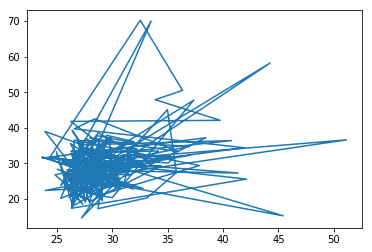

In [21]:
print(results[0])
res = np.array(results)
f,ax = plt.subplots()
ax.plot(res[:,0],res[:,1])

### Random Forest Modeling Results
The Random Forest model cannot predict C-section rates across California hospitals. This could mean that the features that I selected (hospital demographics and characters for which there was publicly available data) may not be primarily responsible for hospital c-section rates. There could be other hospital dynamics (such as staff organization, hospital "culture," etc.) that could be strong influences on C-section rates. Additionally, the limitations of census-level data may not be specific enough to each hospital. Future work to examine more key features, including the use of patient-level data within each hospital, may help more clearly illuminate C-section rates across California hospitals. For now, I will see if statistical analyses can draw more information out key features identified by Random Forest.

In [22]:
len(X_train.columns)

13

## Feature Importance

In [23]:
importances = np.array(importances)
collapsed = np.mean(importances,axis=0)
args = np.argsort(collapsed)
sorted_lst = args,collapsed[args]
print(args,collapsed[args]) #sorts the list
#now there is an array from lowest to highest of feature importance

[ 9  6 12 10  2  7  8 11  3  1  0  5  4] [0.0272297  0.03078485 0.04239543 0.04314841 0.04804746 0.05189401
 0.05575513 0.06002593 0.07094899 0.09631687 0.11078532 0.16275742
 0.19991047]


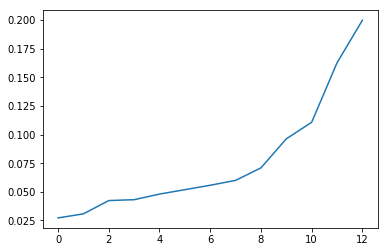

In [24]:
f,ax=plt.subplots()
ax.plot(np.arange(len(collapsed)),collapsed[args])

In [25]:
importances = np.array(importances)
collapsed = np.amax(importances,axis=0)
args = np.argsort(collapsed)
print(args,collapsed[args])
print(X_train.columns.values[args])
#prints the REVERSE order of importance of features

[ 9  6 12 10  2 11  8  7  3  1  0  4  5] [0.06125019 0.07088514 0.08874383 0.10244982 0.10923154 0.11441131
 0.12320511 0.12715506 0.14536795 0.24715189 0.30874255 0.3437563
 0.3791818 ]
['nicu_div_by_births' 'Payer_Medi_Cal_percent' 'PCT200POV'
 'BirthDefects_div_by_births' 'female_patients_percent' 'Dx_preg_percent'
 'Payer_Self_Pay_percent' 'Payer_Priv_Coverage_percent' 'hispanic_percent'
 'TOC_acute_div_by_beds' 'HPSA_SHORTAGE' 'white_percent' 'Admt_Newborn']


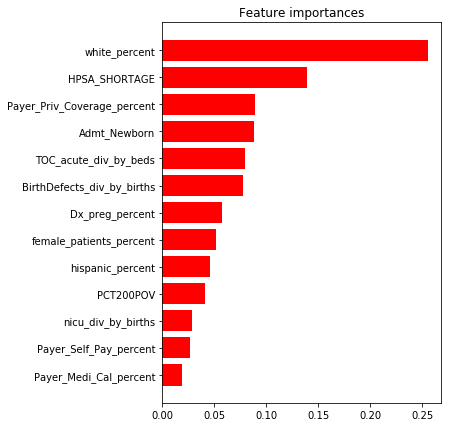

In [26]:
features = X.columns
importance = forest.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances")
plt.barh(features[indices], importance[indices],
       color="r",  align="center");

## Conclusions
The purpose of these analyses was to determine whether there were consistent hospital or demographic factors largely responsible for uncomplicated C-section rates in California maternity hospitals. Random Forest was applied to four multi-variable datasets containing hospital and demographic data from the CA Health and Human Services Open Data Portal. While Random Forest performance in predicting C-section rates in CA hospitals was poor, the model did identify some possible features that could merit additional statistical investigation, including the percent of white patients at the hospital and Health Professional Shortage Area (HPSA) status. 